## Packages

In [283]:
# Packages

#  Standard
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ipython
%matplotlib inline
from IPython.display import display

# Stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.tsa.stattools import adfuller
from scipy.optimize import minimize   

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [284]:
# Styling
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 10)

## Data

### This notebook is Inspired from
https://github.com/rouseguy/TimeSeriesAnalysiswithPython/blob/master/time_series  
and other sources like  
https://github.com/Yorko/mlcourse_open/blob/master/jupyter_english/topic09_time_series/  
https://machinelearningmastery.com/

In [285]:
df_raw = pd.read_csv('data/MonthWiseMarketArrivals_Clean.csv')

In [286]:
display(df_raw.head())
df_raw.sample(5)

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
10217,YEOLA(MS),December,2006,123824,273,656,577,MS,YEOLA,December-2006
1881,CHENNAI,December,2004,130700,386,603,500,TN,CHENNAI,December-2004
7674,PIMPALGAON(MS),June,2006,340936,201,379,308,MS,PIMPALGAON,June-2006
3740,INDORE(MP),September,2015,66714,1375,4238,3373,MP,INDORE,September-2015
5467,LASALGAON(MS),April,2002,193777,55,232,177,MS,LASALGAON,April-2002


In [287]:
# Make a copy of orig df
df = df_raw.copy(deep=True)
print(df.dtypes)

market      object
month       object
year         int64
quantity     int64
priceMin     int64
priceMax     int64
priceMod     int64
state       object
city        object
date        object
dtype: object


In [288]:
# Convert date to DatetimeIndex (time interval)
df['date'] = pd.DatetimeIndex(df['date'])
print(df.dtypes)
df.head()

market              object
month               object
year                 int64
quantity             int64
priceMin             int64
priceMax             int64
priceMod             int64
state               object
city                object
date        datetime64[ns]
dtype: object


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,2005-01-01
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,2006-01-01
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,2010-01-01
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,2011-01-01
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,2012-01-01


In [289]:
# Change index to monthly freq
df.index = pd.PeriodIndex(df.date, freq = 'M')
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2005-01,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,2005-01-01
2006-01,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,2006-01-01
2010-01,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,2010-01-01
2011-01,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,2011-01-01
2012-01,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,2012-01-01


In [290]:
# Sort by date
df = df.sort_values(by = 'date')
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


In [291]:
# Shape, names of cities
df.shape, df['city'].unique() 

((10227, 10),
 array(['LASALGAON', 'NIPHAD', 'SAIKHEDA', 'SINNAR', 'PIMPALGAON', 'LONAND',
        'CHAKAN', 'MANMAD', 'BHAVNAGAR', 'MAHUVA', 'PUNE', 'AHMEDNAGAR',
        'HUBLI', 'RAHURI', 'DEWAS', 'DHAVANGERE', 'BOMBORI', 'DINDIGUL',
        'NASIK', 'GONDAL', 'INDORE', 'DHULIA', 'HASSAN', 'RAJKOT', 'DELHI',
        'KARNAL', 'MANDSOUR', 'JAIPUR', 'KALVAN', 'LUCKNOW',
        'CHICKBALLAPUR', 'SHIMLA', 'KURNOOL', 'SURAT', 'YEOLA', 'KANPUR',
        'KOLAR', 'MALEGAON', 'BELGAUM', 'PATNA', 'SOLAPUR', 'KOLHAPUR',
        'SRINAGAR', 'KOLKATA', 'BANGALORE', 'NAGPUR', 'HYDERABAD', 'MUMBAI',
        'CHENNAI', 'AMRITSAR', 'MADURAI', 'GUWAHATI', 'JALANDHAR', 'RANCHI',
        'UJJAIN', 'BIJAPUR', 'JUNNAR', 'TRIVENDRUM', 'JAMMU', 'AHMEDABAD',
        'SATANA', 'ABOHAR', 'AGRA', 'VARANASI', 'BHUBNESWER', 'JALGAON',
        'SANGALI', 'SANGAMNER', 'BHOPAL', 'JODHPUR', 'SHRIRAMPUR',
        'BHATINDA', 'DEVALA', 'PATIALA', 'LUDHIANA', 'VANI', 'DINDORI',
        'RAIPUR', 'UDAIPUR', 'DEORIA', 

In [292]:
# Bangalore's data
dfb = df[df['city'] == 'BANGALORE'].copy() 
print(dfb.shape)
dfb.head()

(146, 10)


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01


In [293]:
# Keep only necessary columns
dfb.drop(["market", "month", "year", "state", "city", "priceMin", "priceMax"], axis = 1, inplace = True)
dfb.head()

,quantity,priceMod,date
date,,,
2004-01,227832,991,2004-01-01
2004-02,225133,793,2004-02-01
2004-03,221952,556,2004-03-01
2004-04,185150,465,2004-04-01
2004-05,137390,455,2004-05-01


## Models

### Visualize data

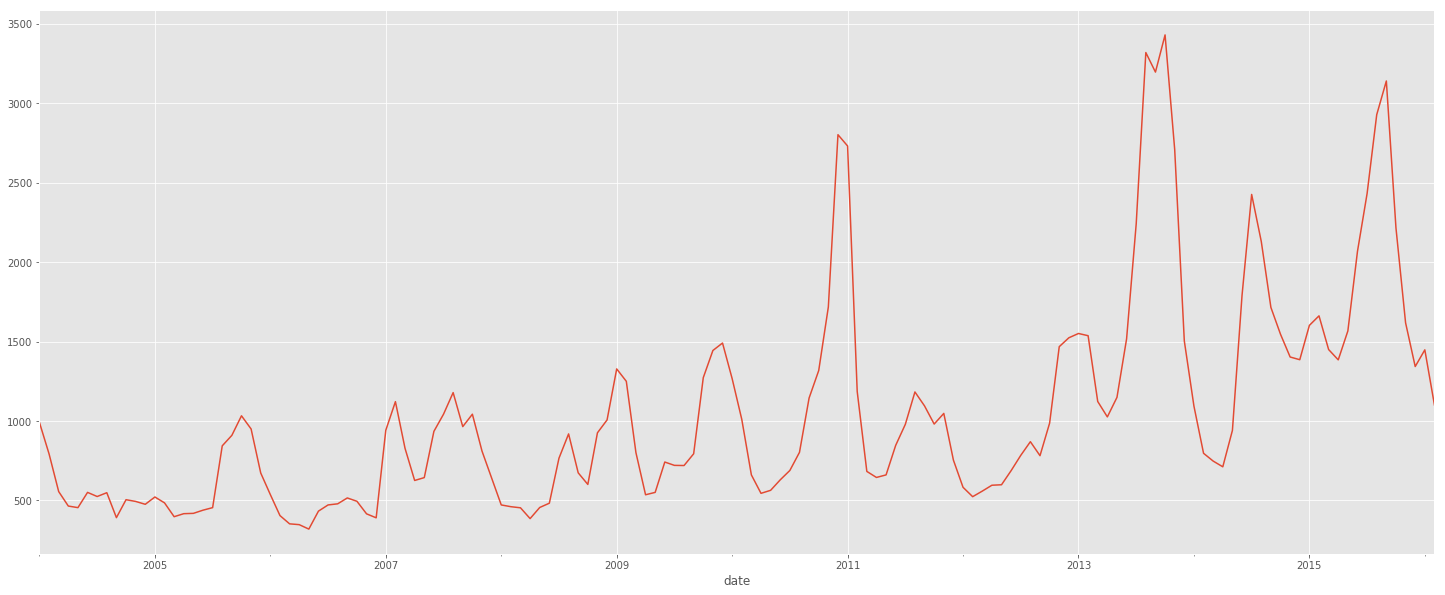

In [294]:
dfb.priceMod.plot()

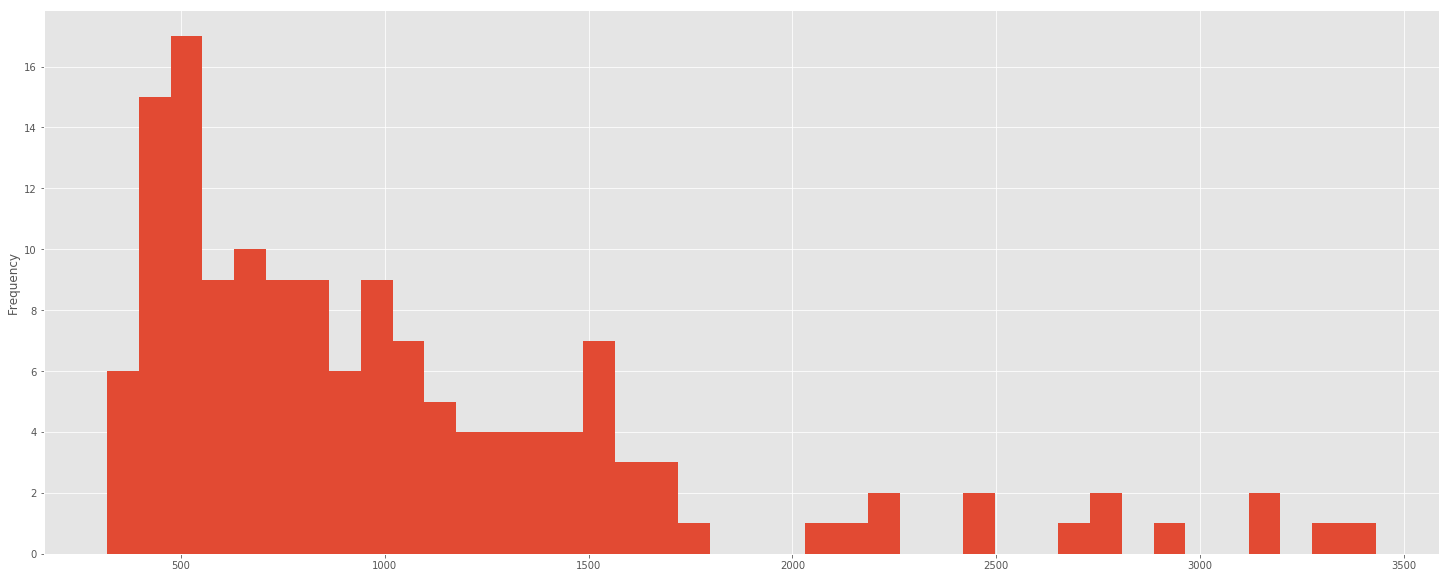

In [295]:
dfb.priceMod.plot(kind = 'hist', bins = 40)

,quantity,priceMod,date,log_priceMod
date,,,,
2004-01,227832,991,2004-01-01,6.898715
2004-02,225133,793,2004-02-01,6.675823
2004-03,221952,556,2004-03-01,6.320768
2004-04,185150,465,2004-04-01,6.142037
2004-05,137390,455,2004-05-01,6.120297


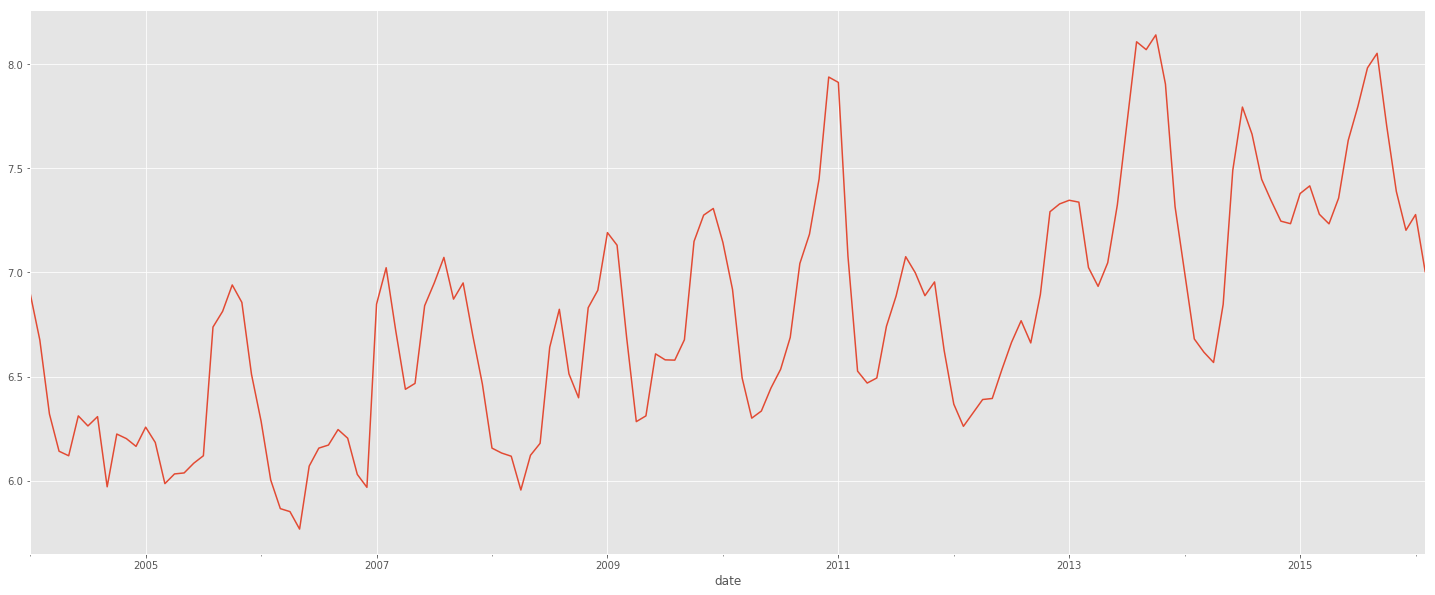

In [296]:
# Reduce the variance using log transformation
dfb['log_priceMod'] = np.log(dfb.priceMod)
display(dfb.head())
dfb.log_priceMod.plot()

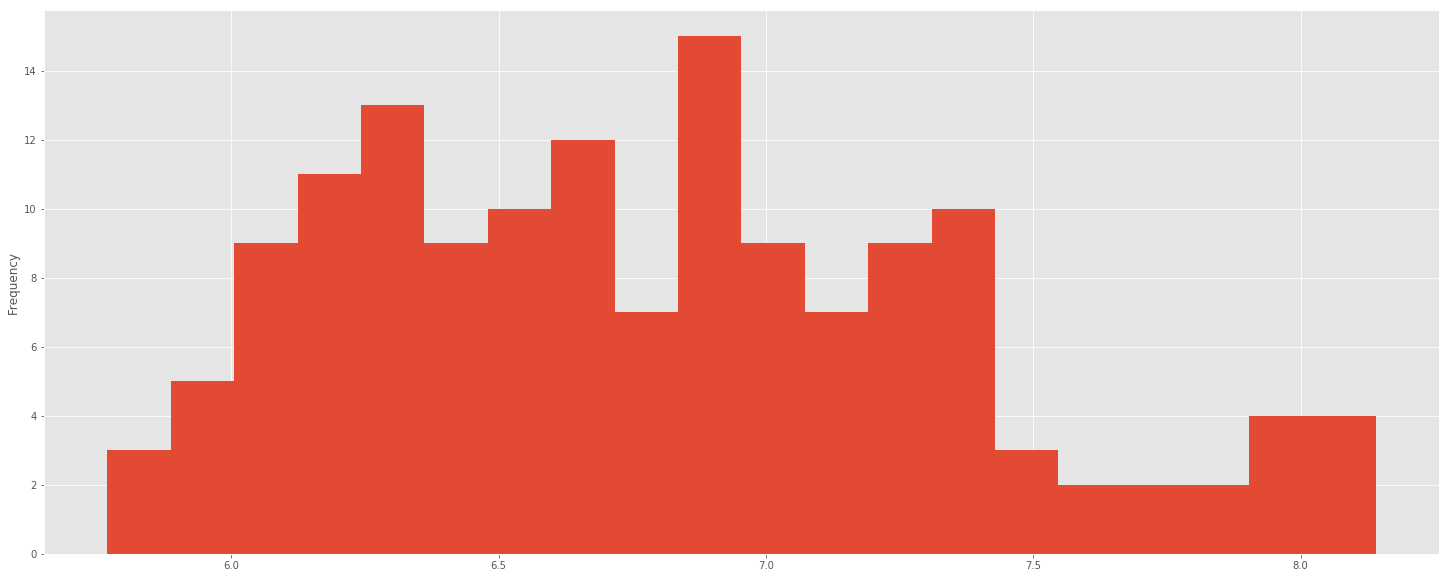

In [297]:
dfb.log_priceMod.plot(kind = 'hist', bins = 20)

### Metrics

In [298]:
# r2_score
# mean absolute error 
# median absolute error
# mean squared error
# mean squared_log_error

from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

def rmse(ytrue, ypred):
    mse = mean_squared_error(ytrue, ypred) ; #(1./ypred.count()) * ((ypred - ytrue)**2).sum() 
    return np.sqrt(mse)

### 1. Mean model

In [299]:
# Mean of all values
dfb['mean_mod'] = np.exp(dfb.log_priceMod.mean())

In [300]:
# Prediction from train data
def pred_price(date, model):
    pred_price = dfb.loc[date, model]
    return pred_price
model = 'mean_mod'
#print(dfb.loc['2004-01', model])
print(pred_price('2004-01', model))

884.565812098


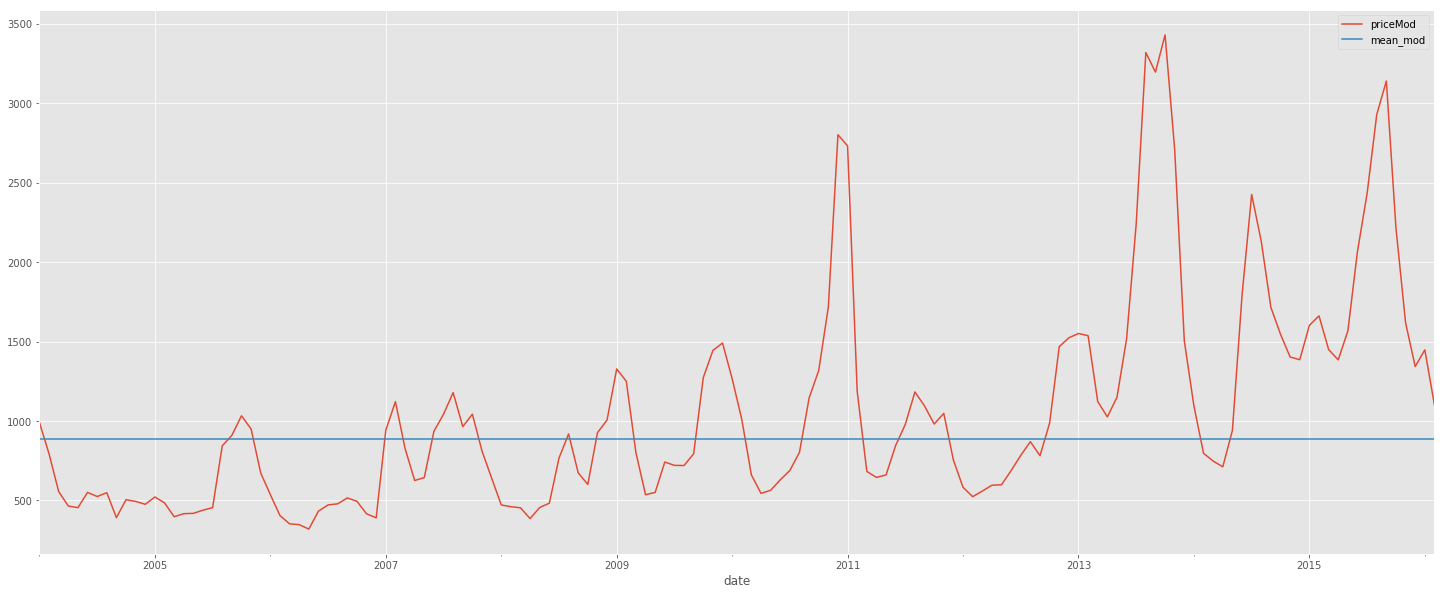

In [301]:
# Plot
models = ['priceMod', 'mean_mod']
dfb.plot(kind = 'line', x = 'date', y= models)

In [302]:
# Error:
err = rmse(dfb['mean_mod'], dfb['priceMod'])
print(err)

683.9533484


### 2. Linear trend or regression model. 
    Features: time

In [303]:
# Convert 'date' into feature for linear regression
print(dfb.dtypes)
dfb['time_feat'] = (dfb.date - dfb.date.min())/np.timedelta64(1,'M')
print(dfb.dtypes)
display(dfb.head())
dfb['time_feat'] = dfb['time_feat'].round(0).astype(int)
display(dfb.head())

quantity                 int64
priceMod                 int64
date            datetime64[ns]
log_priceMod           float64
mean_mod               float64
dtype: object
quantity                 int64
priceMod                 int64
date            datetime64[ns]
log_priceMod           float64
mean_mod               float64
time_feat              float64
dtype: object


,quantity,priceMod,date,log_priceMod,mean_mod,time_feat
date,,,,,,
2004-01,227832,991,2004-01-01,6.898715,884.565812,0.000000
2004-02,225133,793,2004-02-01,6.675823,884.565812,1.018501
2004-03,221952,556,2004-03-01,6.320768,884.565812,1.971293
2004-04,185150,465,2004-04-01,6.142037,884.565812,2.989794
2004-05,137390,455,2004-05-01,6.120297,884.565812,3.975441


,quantity,priceMod,date,log_priceMod,mean_mod,time_feat
date,,,,,,
2004-01,227832,991,2004-01-01,6.898715,884.565812,0
2004-02,225133,793,2004-02-01,6.675823,884.565812,1
2004-03,221952,556,2004-03-01,6.320768,884.565812,2
2004-04,185150,465,2004-04-01,6.142037,884.565812,3
2004-05,137390,455,2004-05-01,6.120297,884.565812,4


In [304]:
# Linear regression: 
from sklearn.linear_model import LinearRegression

# Fit
X_tr = pd.DataFrame(dfb['time_feat'])
y_tr = dfb['log_priceMod']
lr = LinearRegression()
lr.fit(X_tr, y_tr)

# Pred:
ypred = lr.predict(X_tr)
model = 'lin_mod_1'
dfb['lin_mod_1'] = np.exp(ypred)

In [305]:
# Prediction from train data
def pred_price(date, model):
    pred_price = dfb.loc[date, model]
    return pred_price
#print(dfb.loc['2004-01', model])
print(pred_price('2004-01', model))

451.289090374


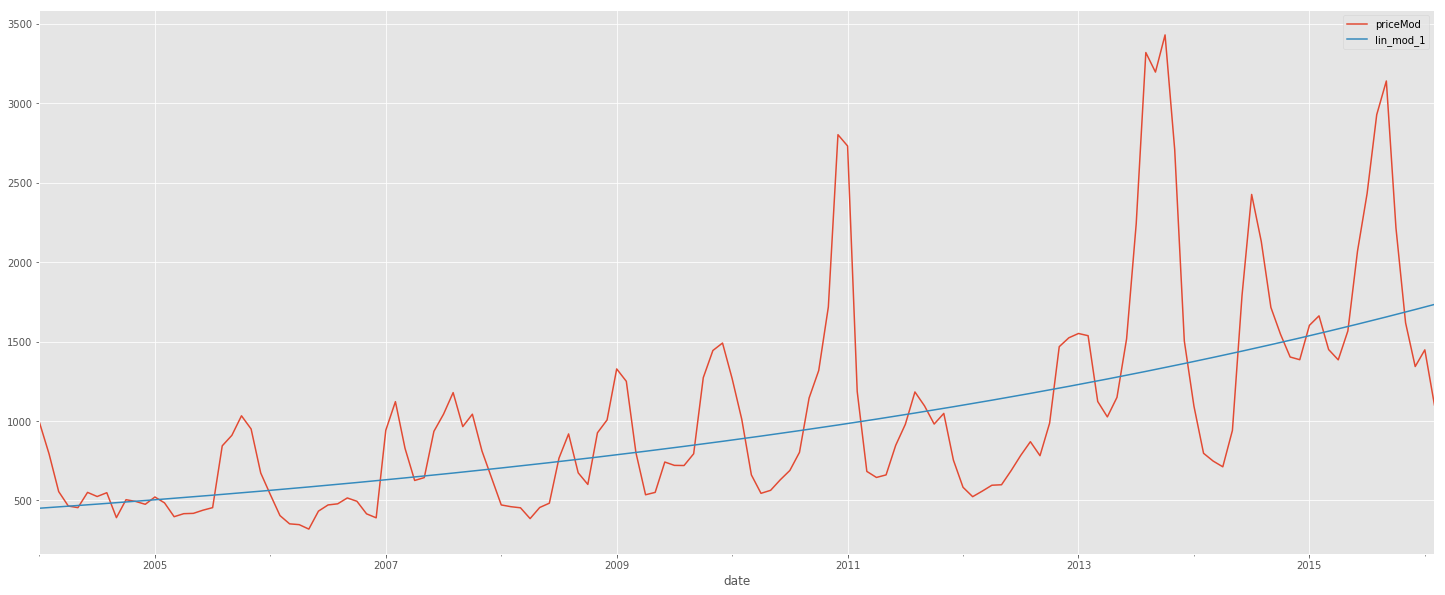

In [306]:
# Plot
models = ['priceMod', model]
dfb.plot(kind = 'line', x = 'date', y= models)

In [307]:
# Error:
err = rmse(dfb[model], dfb['priceMod'])
print(err)

518.523607584


### 3. Linear trend or regression model. 
    Features (from feature engineering): past prices (lag), month of year

In [308]:
## Add previous prices as features - e.g. 1 time step old price
display(dfb['priceMod'][:10])
display(dfb['priceMod'].shift(1)[:10])

date
2004-01    991
2004-02    793
2004-03    556
2004-04    465
2004-05    455
2004-06    551
2004-07    525
2004-08    549
2004-09    392
2004-10    505
Freq: M, Name: priceMod, dtype: int64

date
2004-01      NaN
2004-02    991.0
2004-03    793.0
2004-04    556.0
2004-05    465.0
2004-06    455.0
2004-07    551.0
2004-08    525.0
2004-09    549.0
2004-10    392.0
Freq: M, Name: priceMod, dtype: float64

In [309]:
# Add 6 - 18 timestep lag prices
dfb_reg = dfb.copy()
for i in range(6,18):
    dfb_reg['price_{}_ago'.format(i)] =  dfb_reg['log_priceMod'].shift(i)
dfb_reg.head()

,quantity,priceMod,date,log_priceMod,mean_mod,time_feat,lin_mod_1,price_6_ago,price_7_ago,price_8_ago,price_9_ago,price_10_ago,price_11_ago,price_12_ago,price_13_ago,price_14_ago,price_15_ago,price_16_ago,price_17_ago
date,,,,,,,,,,,,,,,,,,,
2004-01,227832,991,2004-01-01,6.898715,884.565812,0,451.289090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02,225133,793,2004-02-01,6.675823,884.565812,1,455.497732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03,221952,556,2004-03-01,6.320768,884.565812,2,459.745622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04,185150,465,2004-04-01,6.142037,884.565812,3,464.033127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05,137390,455,2004-05-01,6.120297,884.565812,4,468.360617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [310]:
# Features
drop_feat = ['date', 'log_priceMod', 'priceMod', 'quantity', 'mean_mod', 'lin_mod_1','time_feat']
X_tr = dfb_reg.dropna().drop(drop_feat, axis = 1)
y_tr = dfb_reg.dropna().log_priceMod

# Fit
lr = LinearRegression()
lr.fit(X_tr, y_tr)

# Preds
ypred = lr.predict(X_tr)
dfb['lin_mod_2'] = np.zeros((dfb.shape[0],1))
dfb.loc['2005-06':, 'lin_mod_2'] =  np.exp(ypred)

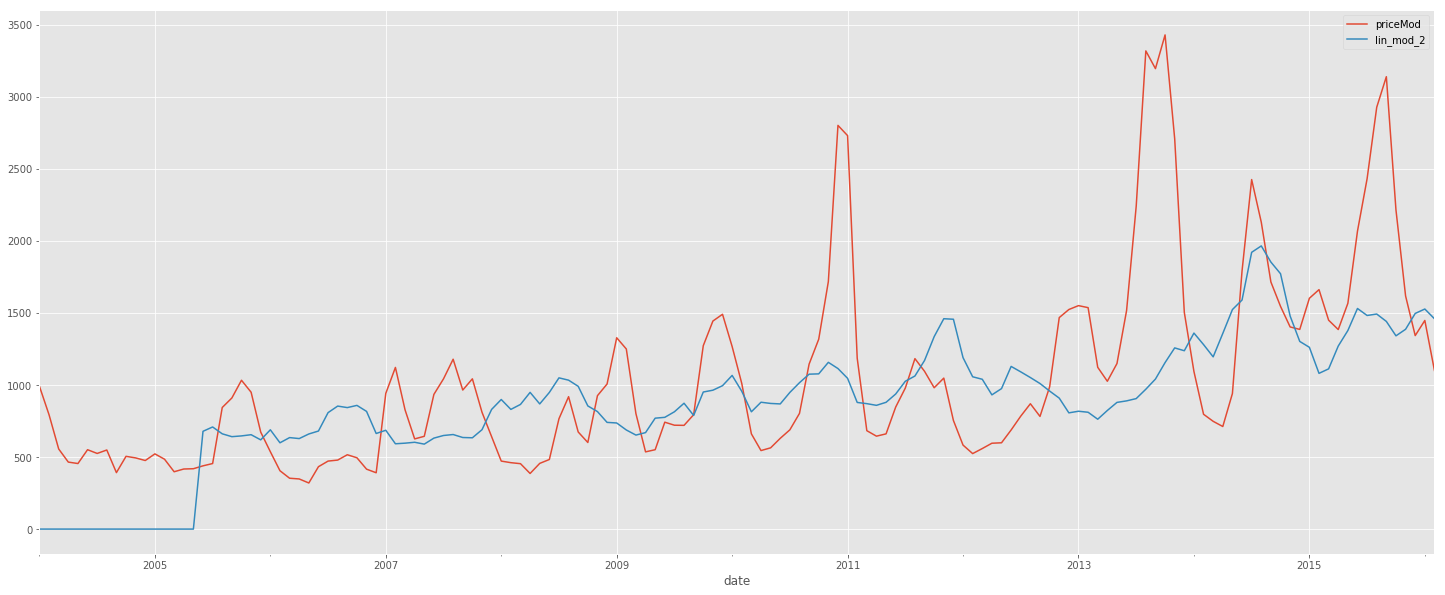

In [311]:
# Plot
models = ['priceMod', 'lin_mod_2']
dfb.plot(kind = 'line', x = 'date', y= models)

In [312]:
# Error:
err = rmse(dfb['lin_mod_2'], dfb['priceMod'])
print(err)

591.808913628


In [313]:
# Add month as feature
dfb_reg['month'] = dfb_reg.index.month
dfb_reg.head()

,quantity,priceMod,date,log_priceMod,mean_mod,time_feat,lin_mod_1,price_6_ago,price_7_ago,price_8_ago,price_9_ago,price_10_ago,price_11_ago,price_12_ago,price_13_ago,price_14_ago,price_15_ago,price_16_ago,price_17_ago,month
date,,,,,,,,,,,,,,,,,,,,
2004-01,227832,991,2004-01-01,6.898715,884.565812,0,451.289090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2004-02,225133,793,2004-02-01,6.675823,884.565812,1,455.497732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2004-03,221952,556,2004-03-01,6.320768,884.565812,2,459.745622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2004-04,185150,465,2004-04-01,6.142037,884.565812,3,464.033127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2004-05,137390,455,2004-05-01,6.120297,884.565812,4,468.360617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [314]:
# Including month feature
drop_feat = ['date', 'log_priceMod', 'priceMod', 'quantity', 'mean_mod', 'lin_mod_1','time_feat']
X_tr = dfb_reg.dropna().drop(drop_feat, axis = 1)
y_tr = dfb_reg.dropna().log_priceMod

# fit
lr = LinearRegression()
lr.fit(X_tr, y_tr)

# Preds
ypred = lr.predict(X_tr)
dfb['lin_mod_3'] = np.zeros((dfb.shape[0],1))
first_idx = str(dfb_reg.dropna().index[0]) ; # '2005-06'
dfb.loc[first_idx:, 'lin_mod_3'] =  np.exp(ypred)

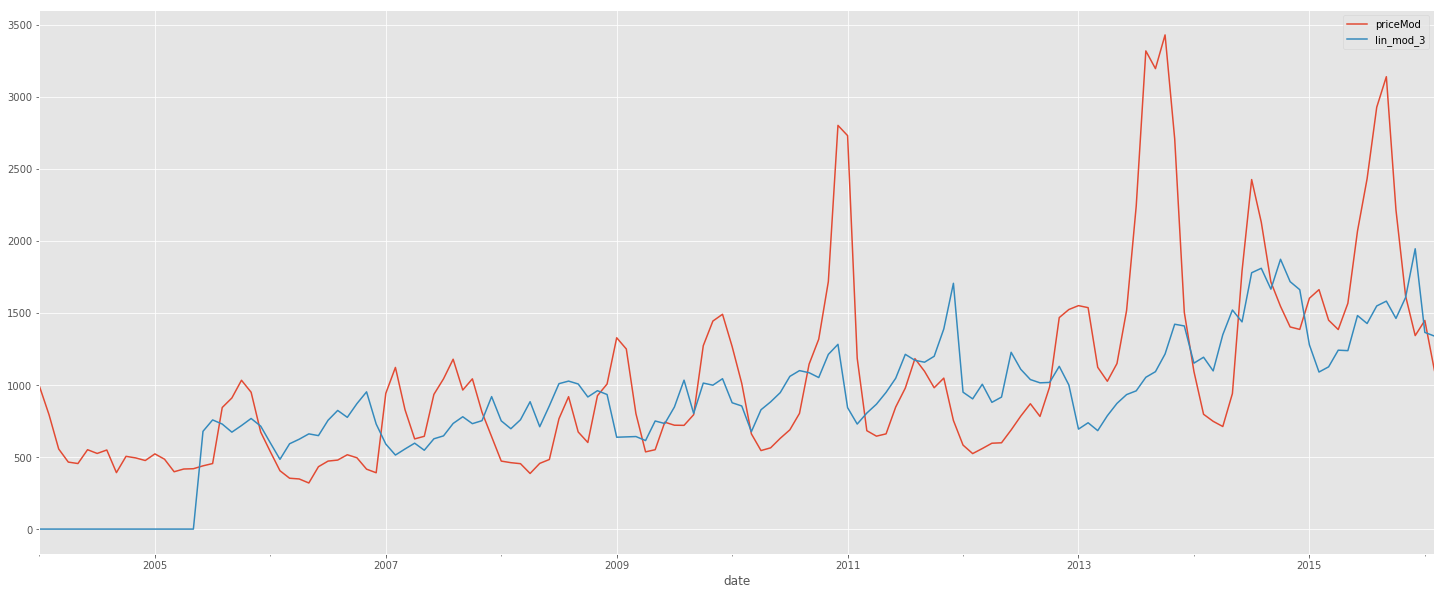

In [315]:
# Plot
models = ['priceMod', 'lin_mod_3']
dfb.plot(kind = 'line', x = 'date', y= models)

In [316]:
# Error:
err = rmse(dfb['lin_mod_2'], dfb['priceMod'])
print(err)

591.808913628


### 4. Linear trend or regression model using stats package. 
    Features: time and quantiy feature

In [317]:
# Add month as feature
dfb['month'] = dfb.index.month
dfb.head()

,quantity,priceMod,date,log_priceMod,mean_mod,time_feat,lin_mod_1,lin_mod_2,lin_mod_3,month
date,,,,,,,,,,
2004-01,227832,991,2004-01-01,6.898715,884.565812,0,451.289090,0.0,0.0,1
2004-02,225133,793,2004-02-01,6.675823,884.565812,1,455.497732,0.0,0.0,2
2004-03,221952,556,2004-03-01,6.320768,884.565812,2,459.745622,0.0,0.0,3
2004-04,185150,465,2004-04-01,6.142037,884.565812,3,464.033127,0.0,0.0,4
2004-05,137390,455,2004-05-01,6.120297,884.565812,4,468.360617,0.0,0.0,5


In [318]:
lin_mod_stats = smf.ols('log_priceMod ~ time_feat + month', data = dfb).fit()
lin_mod_stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_priceMod   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     79.44
Date:                Sun, 20 May 2018   Prob (F-statistic):           6.29e-24
Time:                        18:28:03   Log-Likelihood:                -67.295
No. Observations:                 146   AIC:                             140.6
Df Residuals:                     143   BIC:                             149.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9308      0.085     69.395      0.000       5.762       6.100
time_feat      0.0092      0.001     12.032      0.000       0.008       0.011
month          0.0295      0.009      3.191      0.002       0.011       0.048
==============================================================================
Omnibus:                        7.406   Durbin-Watson:                   0.481
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.766
Skew:                           0.553   Prob(JB):                       0.0206
Kurtosis:                       2.772   Cond. No.                         224.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [319]:
dfb['lin_mod_4'] = np.exp(lin_mod_stats.predict())

In [320]:
# Prediction from train data
def pred_price(date, model):
    pred_price = dfb.loc[date, model]
    return pred_price
model = 'lin_mod_4'
#print(dfb.loc['2004-01', model])
print(pred_price('2004-01', model))

387.705923474


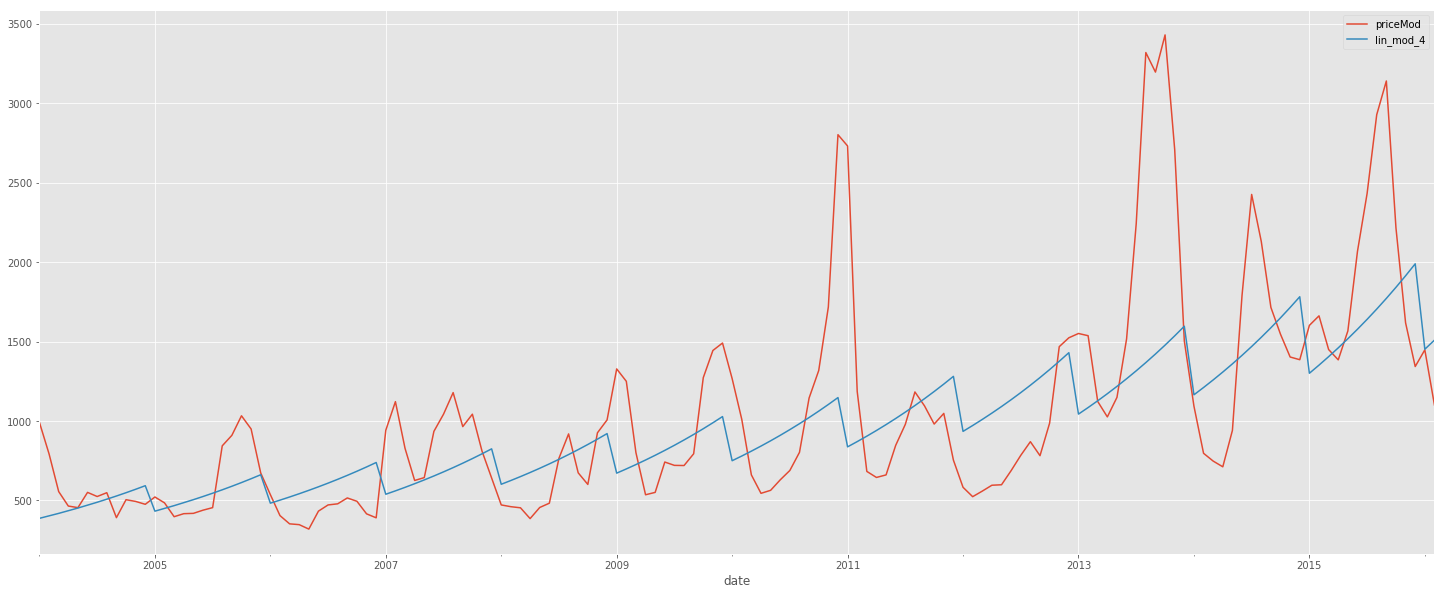

In [321]:
# Plot
models = ['priceMod', 'lin_mod_4']
dfb.plot(kind = 'line', x = 'date', y= models)

In [322]:
# Error:
err = rmse(dfb['lin_mod_4'], dfb['priceMod'])
print(err)

496.813103774


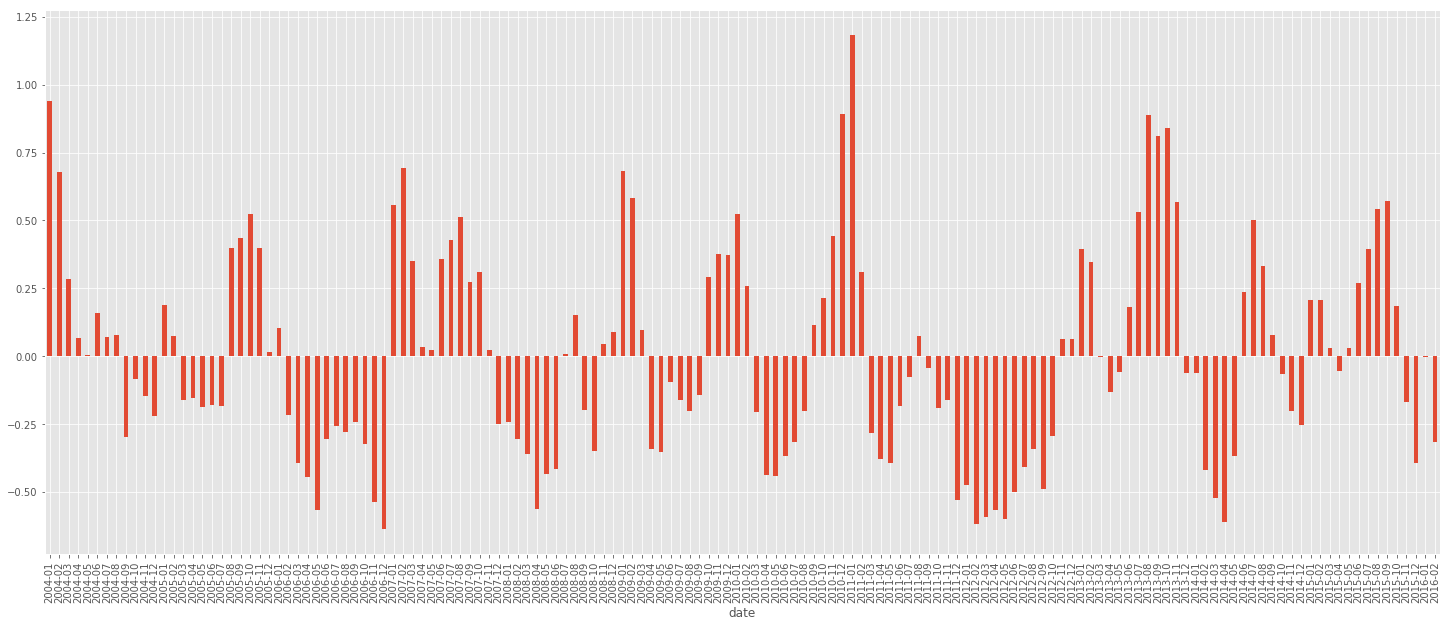

In [323]:
lin_mod_stats.resid.plot(kind = 'bar')

The residuals or errors seem to have a pattern and seem correlated with time.
(lag-1 autocorrelation is not 0. Durban-Watson statistic is not 2)

### 5. Random walk

In [324]:
# Add 6 - 18 timestep lag prices
dfb['randwalk_mod'] =  np.exp(dfb['log_priceMod'].shift())

In [325]:
# Prediction from train data
def pred_price(date, model):
    pred_price = dfb.loc[date, model]
    return pred_price
model = 'randwalk_mod'
#print(dfb.loc['2004-01', model])
print(pred_price('2004-02', model))

991.0


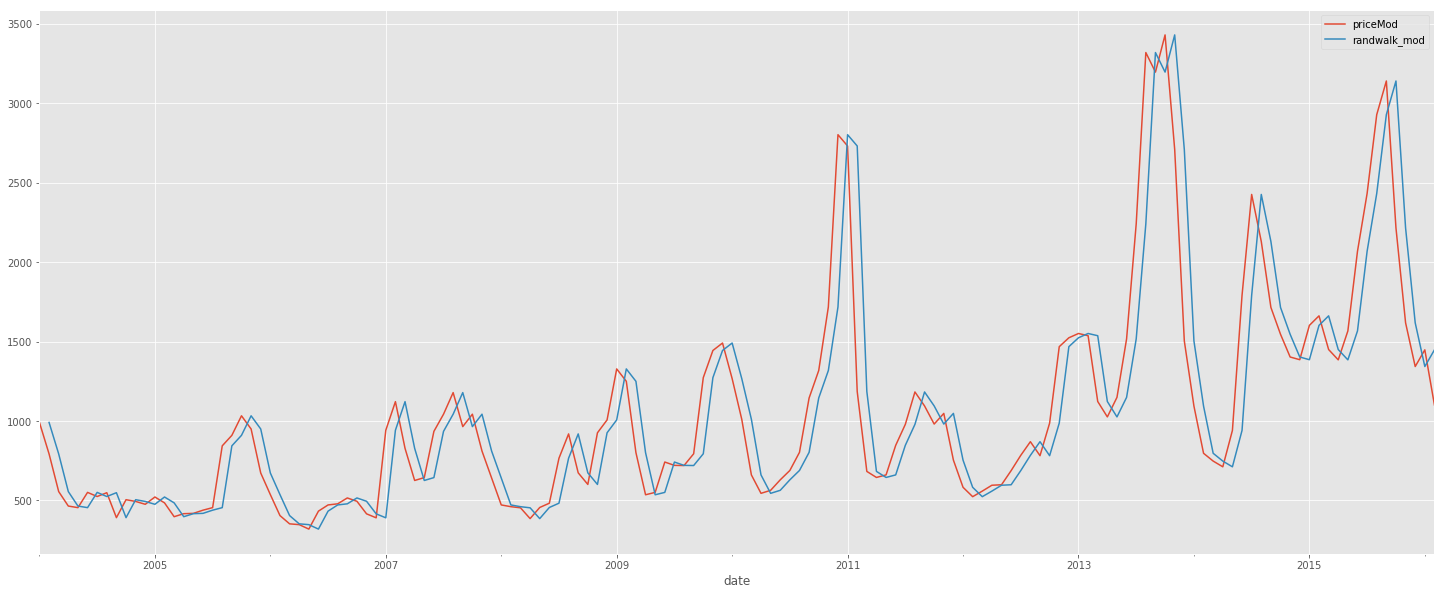

In [326]:
# Plot
models = ['priceMod', model]
dfb.plot(kind = 'line', x = 'date', y= models)

In [327]:
# Error:
err = rmse(dfb[model].fillna(0.0), dfb['priceMod'])
print(err)

332.748279948


### 6. Simple moving average (between mean and random walk)

In [328]:
# Moving average over previous window values
window = 6
dfb['smavg_mod'] = np.exp(dfb.log_priceMod.rolling(window=window).mean())

In [329]:
# Prediction from train data
def pred_price(date, model):
    pred_price = dfb.loc[date, model]
    return pred_price
model = 'smavg_mod'
#print(dfb.loc['2004-01', model])
print(pred_price('2005-01', model))

486.996341944


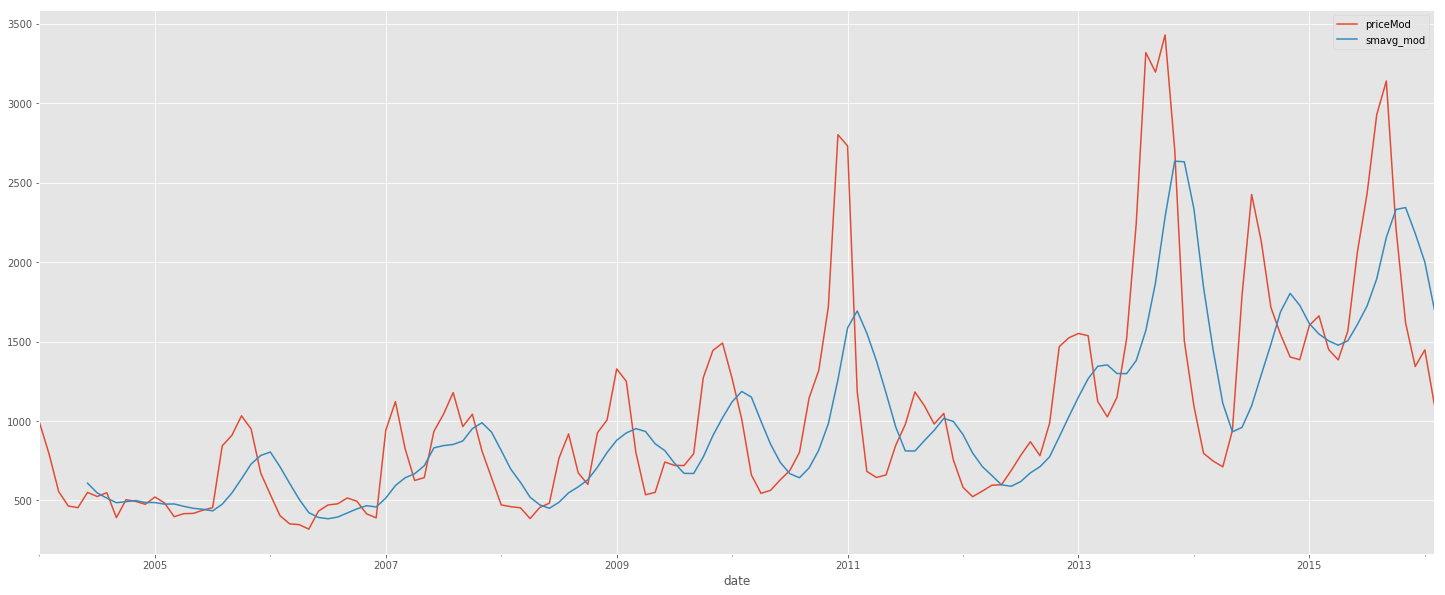

In [330]:
# Plot
models = ['priceMod', model]
dfb.plot(kind = 'line', x = 'date', y= models)

In [331]:
# Error:
#dfb[model] = dfb[model].fillna(0.0)
err = rmse(dfb[model].dropna(), dfb.loc[str(dfb.index[window-1]):,'priceMod'])
print(err)

475.527319801


### 7. SImple exponential smoothing
    ypred_t = alpha.y_t + (1-alpha).ypred_t-1

#### Half-life 12

In [332]:
# Exponential weighted average over previous values
halflife = 12
alpha = 1 - np.exp(np.log(0.5)/halflife)
dfb['ewmavg_mod_{}'.format(halflife)] = np.exp(dfb.log_priceMod.ewm(halflife=12).mean())
print("alpha:", alpha)

alpha: 0.0561256873183


In [333]:
# Prediction from train data
def pred_price(date, model):
    pred_price = dfb.loc[date, model]
    return pred_price
model = 'ewmavg_mod_12'
#print(dfb.loc['2004-01', model])
print(pred_price('2005-01', model))

528.067083028


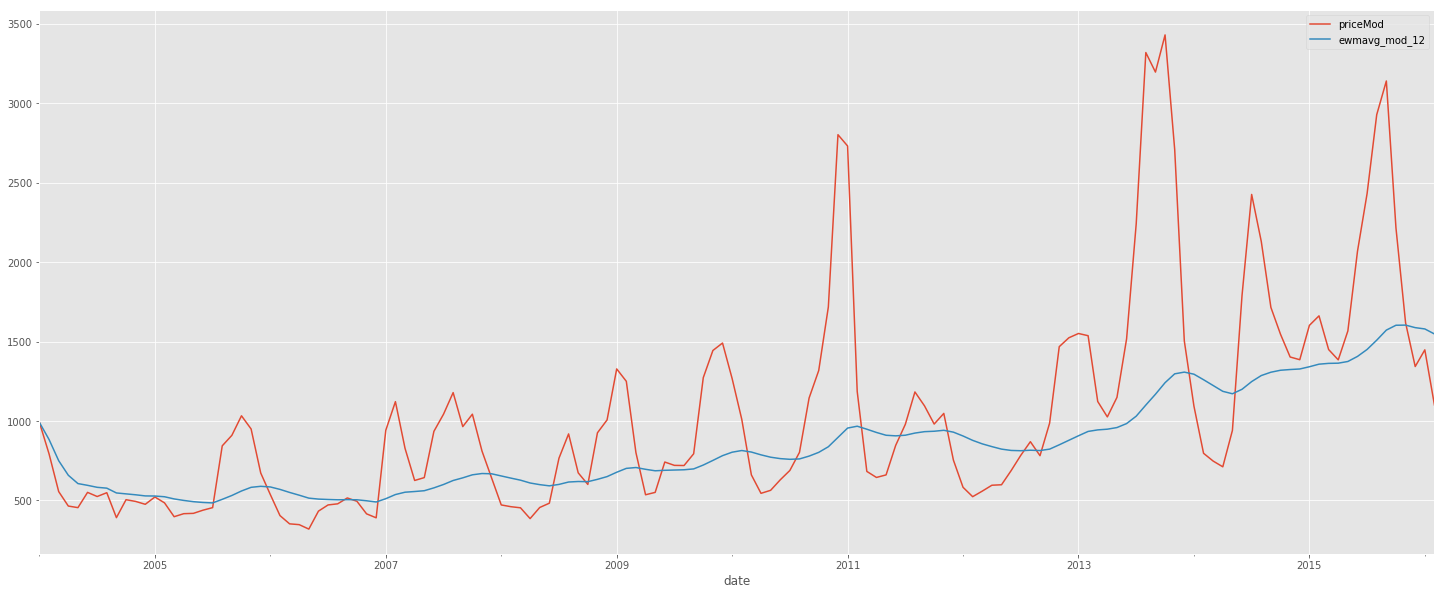

In [334]:
# Plot
models = ['priceMod', model]
dfb.plot(kind = 'line', x = 'date', y= models)

In [335]:
# Error:
err = rmse(dfb[model], dfb['priceMod'])
print(err)

547.162810933


#### Half-life 6

In [336]:
# Exponential weighted average over previous values
halflife = 6
alpha = 1 - np.exp(np.log(0.5)/halflife)
dfb['ewmavg_mod_{}'.format(halflife)] = np.exp(dfb.log_priceMod.ewm(halflife=halflife).mean())
print("alpha:", alpha)

alpha: 0.10910128186


In [337]:
# Prediction from train data
def pred_price(date, model):
    pred_price = dfb.loc[date, model]
    return pred_price
model = 'ewmavg_mod_6'
#print(dfb.loc['2004-01', model])
print(pred_price('2005-01', model))

516.718838169


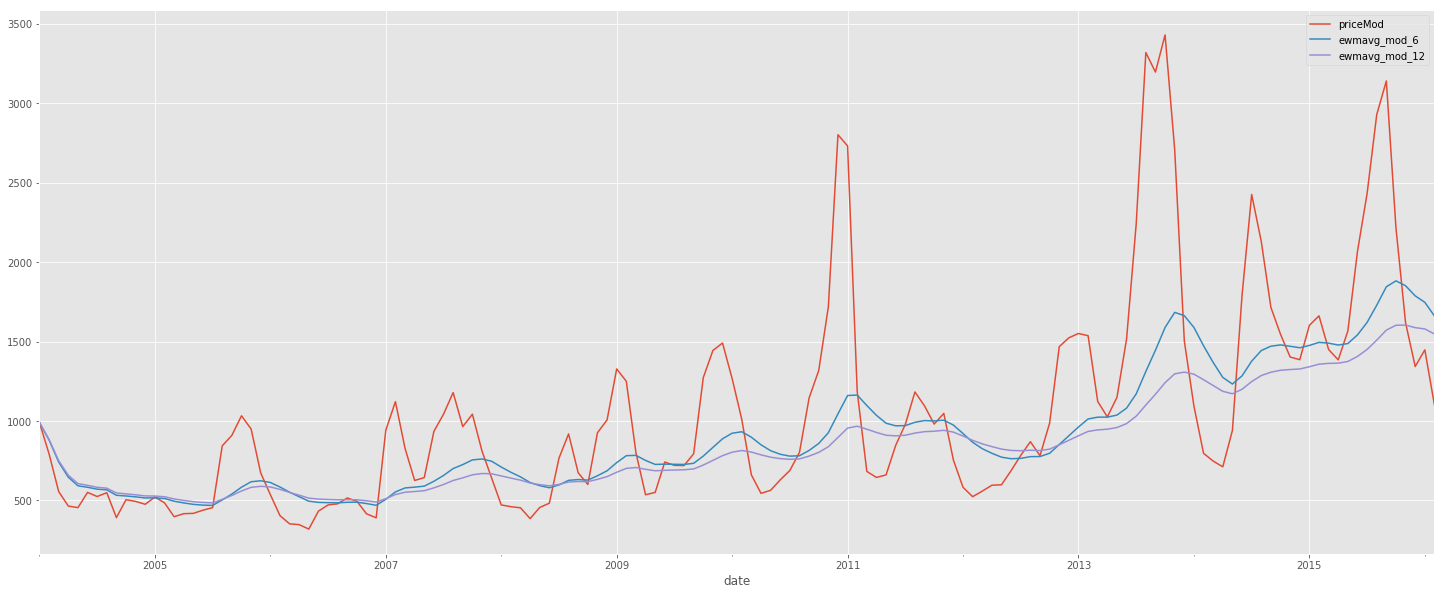

In [338]:
# Plot
models = ['priceMod', model, 'ewmavg_mod_12']
dfb.plot(kind = 'line', x = 'date', y= models)

In [339]:
# Error:
err = rmse(dfb[model], dfb['priceMod'])
print(err)

486.896051347


### Predictions for long-term using above simple models:


- Mean model: Constant value
- Random walk model: Last observed value
- Linear trend model: Use the regression model to predict
- Simple / exponential weighted moving average: Average / Exp weighted avg of last window size observed values


### Stationary TS theory / terms

#### Terms:

##### Key terms:

    - Trend: 
        - Uptrend (high highs and high lows) with time
        - Downtrend (low highs and low lows) with time
        
    - Seasonality:
        - Repeating pattern every fixed period   
       
    - Cyclic:
        - Repeating pattern with no fixed period

    - Error:
       - Residuals not explained by Trend or seasonality

    - Stationary series:
        - Constant mean and variance over time
        - Covariance doesnt changw with time. covariance of y(ti) and y(ti+n) is constant 
        - Trend stationary, Seasonality stationary
        
##### Why make time-series stationary?
        - Because models usually predict statistical properties or summary statistics
        - Future statistical properties should be similar
        - Remove the time-dependency in the observations 
          (i.e. the observations are not dependent on time in stationary time-series)
        - Summary statisitics (like mean,variance) will then be consistent over time
        - Statistical modeling methods assume / need this.

##### Stationary or not for machine learning models?
        - ML models can use non-stationary structure to get better models
        - Keep the information if stationary or not for feature engineering/selection

##### ETS models:

    - Additive models:
        - y_t = Seas_t + Tre_t + Err_t 
        - When variance of Seas, Err is constant
        - And Tre changes linearly

    - Multiplicative models:
        - y_t = Seas_t * Tre_t * Err_t 
        - When variance of Seas, Err is increasing or decreasing
        - And Tre changes exponentially
        
##### ARIMA models:

#### How to check stationary?
    - Visually with plots for any Trend, Seasonality with time.
      (Non-gaussian distribution of y in histogram could be a hint)
    - Summary stats (like mean, variance) on different parts of data
    - Stat test like Augmented Dickey-Fuller test

#### Augmented Dickey-fuller test

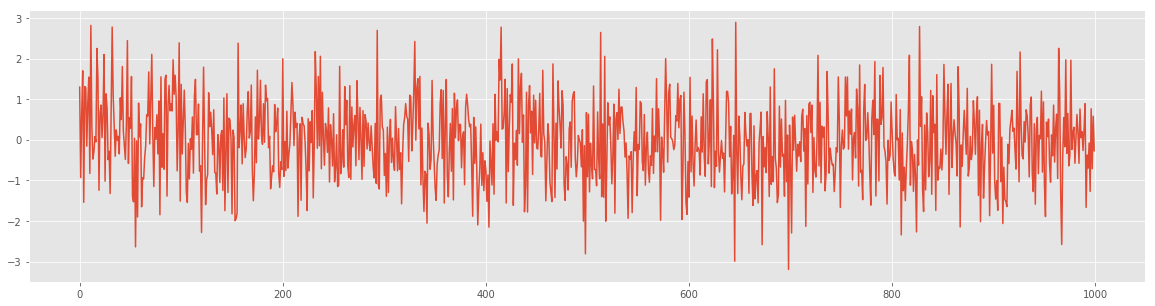

In [340]:
# Stationary series with mean 0 and stddev 1
noise = np.random.normal(size=1000)
plt.figure(figsize = (20,5))
plt.plot(noise)

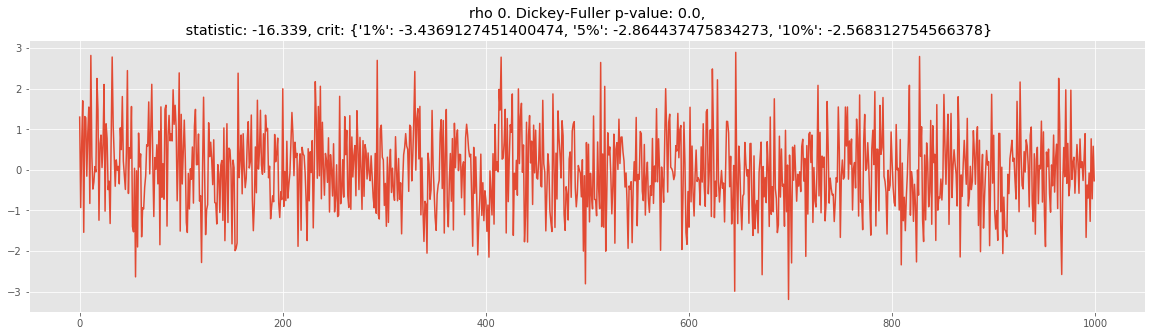

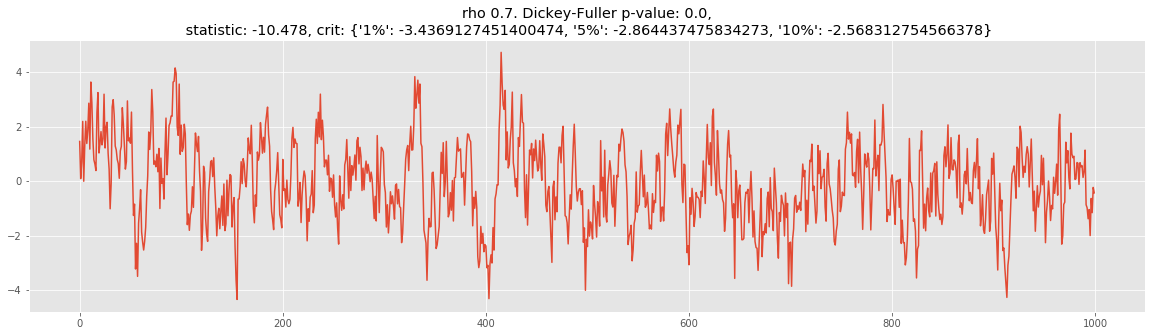

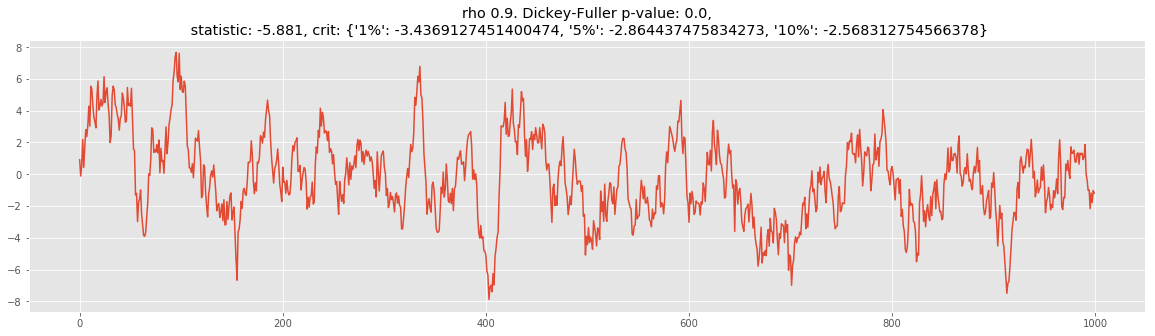

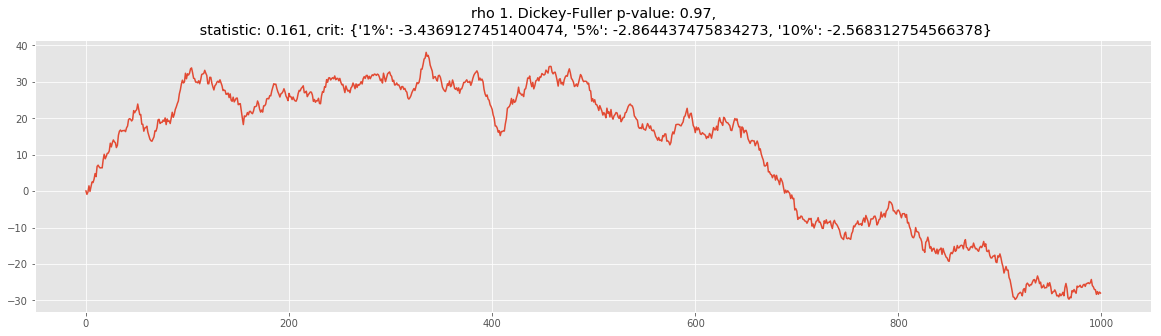

In [341]:
#noise = np.random.normal(size=1000)
for rho in [0, 0.7, 0.9, 1]:
    test = np.random.normal(size=1000)
    for i in range(1000):
        test[i] = rho*test[i-1] +  noise[i]
    plt.figure(figsize = (20,5))
    plt.plot(test)
    adf_result = sm.tsa.stattools.adfuller(test)
    adf_p_value = round(adf_result[1], 3)
    adf_stat = round(adf_result[0], 3)
    adf_crit = adf_result[4]
    plt.title("rho {}. Dickey-Fuller p-value: {},\n statistic: {}, crit: {}".format(rho, adf_p_value, adf_stat, adf_conf))

- Null hypothesis: 
    The time-series can be represented by unit root (i.e. its non-stationary)  
    - Assume threshold is 5%
    - Accept null hypothesis if p-value > 0.05 --> Non-stationary
    - Reject null hypothesis if p-value <= 0.05 --> Stationary
    - ADF statistic will be very negative (and less than crit values) if Stationary. 
 
  
- Here:
    - p-value of test1-3 <= 0.05 --> Stationary 
    - p-value of test4 > 0.05 --> Non-stationary 

### 8. Make TS stationary 

#### 1. Differencing

In [342]:
# Usually with some time period (1 or seasonal time period)
shift_timeunits = 1
dfb['diff1_log_priceMod'] =  dfb['log_priceMod'] - dfb['log_priceMod'].shift(shift_timeunits)

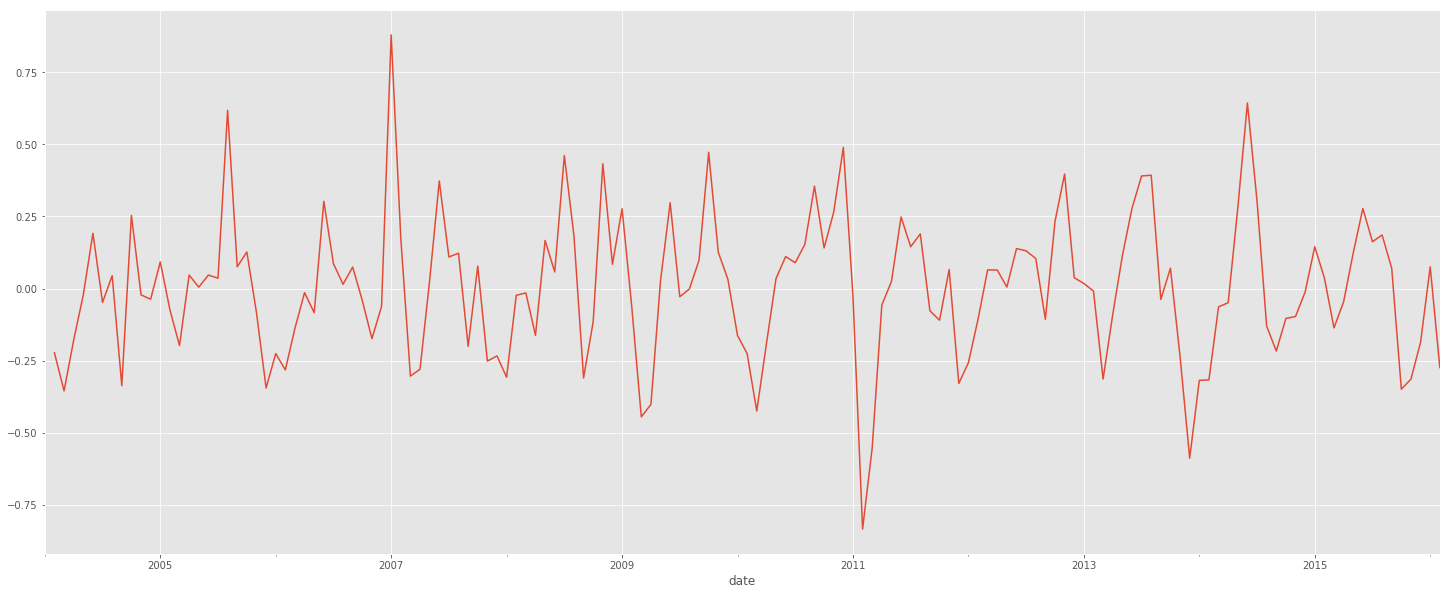

In [343]:
dfb.diff1_log_priceMod.plot()

In [344]:
# Check for stationarity in original
adf_result = sm.tsa.stattools.adfuller(dfb.log_priceMod)
adf_p_value = round(adf_result[1], 3)
adf_stat = round(adf_result[0], 3)
adf_crit = adf_result[4]
print("Dickey-Fuller p-value: {},\n statistic: {}, crit: {}".format(adf_p_value, adf_stat, adf_conf))

Dickey-Fuller p-value: 0.005,
 statistic: -3.651, crit: {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}


In [345]:
# Check for stationarity in differenced series
temp_ts = dfb.diff1_log_priceMod.dropna()
adf_result = sm.tsa.stattools.adfuller(temp_ts)
adf_p_value = round(adf_result[1], 3)
adf_stat = round(adf_result[0], 3)
adf_crit = adf_result[4]
print("Dickey-Fuller p-value: {},\n statistic: {}, crit: {}".format(adf_p_value, adf_stat, adf_conf))

Dickey-Fuller p-value: 0.0,
 statistic: -7.293, crit: {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}


#### 2. Decomposition into trend, seasonal, residuals

/home/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: to_datetime is deprecated. Use self.to_timestamp(...)
  after removing the cwd from sys.path.


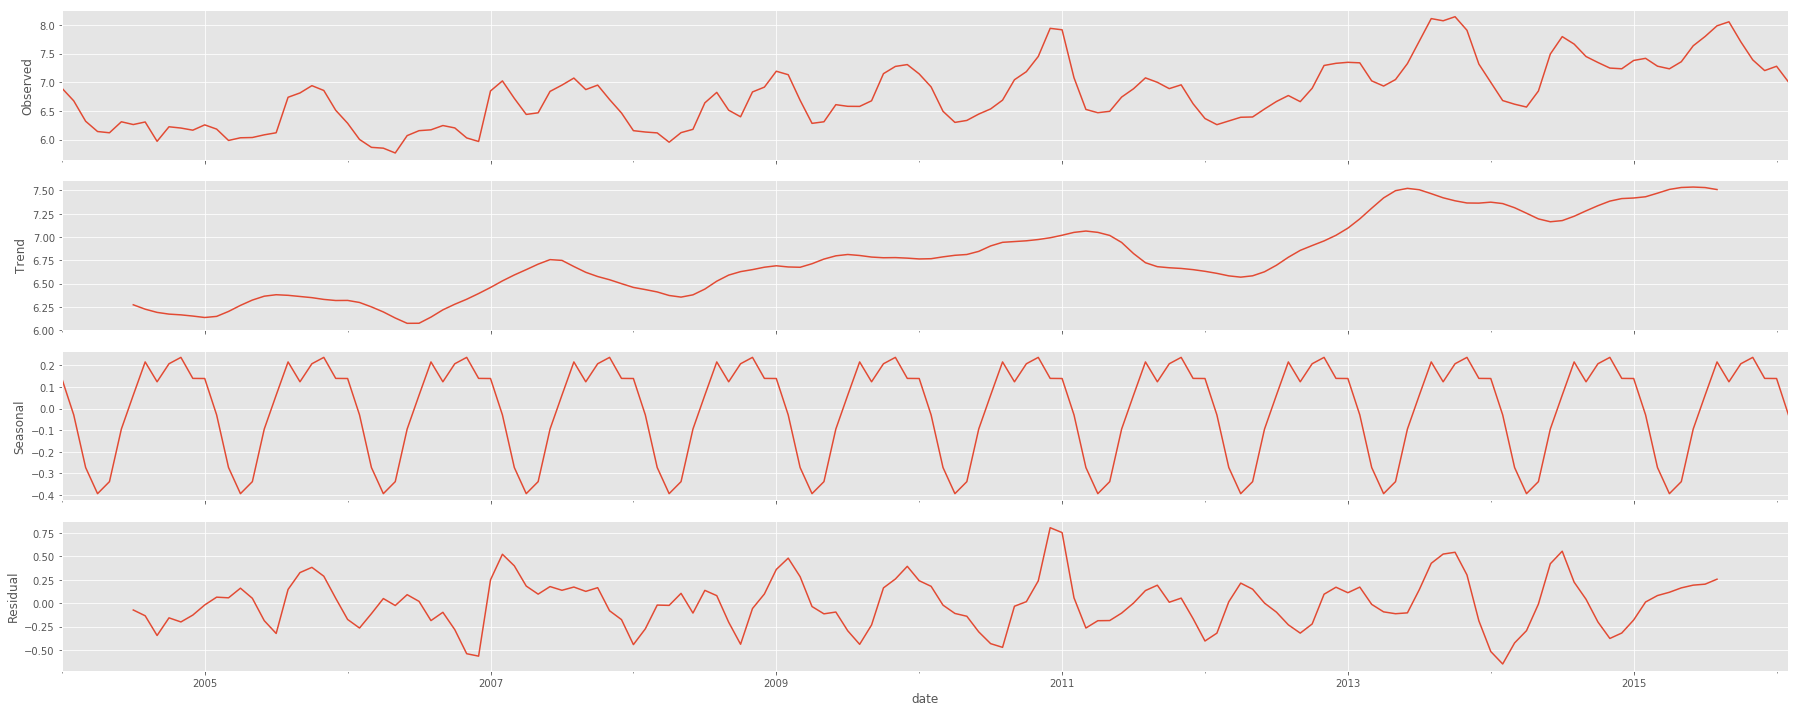

In [346]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Doesnt accept PeriodIndex. Change to DateTimeIndex
dfb.index = dfb.index.to_datetime()

# Decompose
decomp_results = seasonal_decompose(dfb.log_priceMod, model = 'additive')

# Check results
decomp_results.plot()
trend = decomp_results.trend 
seasonal = decomp_results.seasonal 
resid = decomp_results.resid

In [347]:
# Check for stationarity in original
adf_result = sm.tsa.stattools.adfuller(dfb.log_priceMod)
adf_p_value = round(adf_result[1], 3)
adf_stat = round(adf_result[0], 3)
adf_crit = adf_result[4]
print("Dickey-Fuller p-value: {},\n statistic: {}, crit: {}".format(adf_p_value, adf_stat, adf_conf))

Dickey-Fuller p-value: 0.005,
 statistic: -3.651, crit: {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}


In [348]:
# Check for stationarity in residuals
resid.dropna(inplace = True)
adf_result = sm.tsa.stattools.adfuller(resid)
adf_p_value = round(adf_result[1], 3)
adf_stat = round(adf_result[0], 3)
adf_crit = adf_result[4]
print("Dickey-Fuller p-value: {},\n statistic: {}, crit: {}".format(adf_p_value, adf_stat, adf_conf))

Dickey-Fuller p-value: 0.0,
 statistic: -7.907, crit: {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}


### 9. ARIMA 

#### Theory / terms

- Auto-regressive (p = # of lags)
    - Linear combination of past p values
    - Random walk is AR(1) with c = 0. Random walk with drift has c!=0.
  
  
- Integrated (d = # of differencings)
    - Differencing to make series stationary.
    - E.g. if differencing 1 makes it stationary, can pass original series and d=1.
    - If differencing already done, pass new series and d=0.
  
  
- Moving average (q = # of lag forecast errors)
    - Linear combination of past q forecast errors. 
      (error is diff between moving average at that time and actual value)

- How to find p, q?

    - Auto correlation function (ACF): Correlation between TS and lagged version of itself.  
        
    - Partial auto-correlation function (PACF): Correlation between TS and lagged version of itself. But remove variations explained by intermediate lags.  

#### Plot ACF and PACF

In [349]:
from statsmodels.tsa.stattools import acf, pacf

# Drop na in difference TS
ts_stat = dfb['diff1_log_priceMod'].dropna()

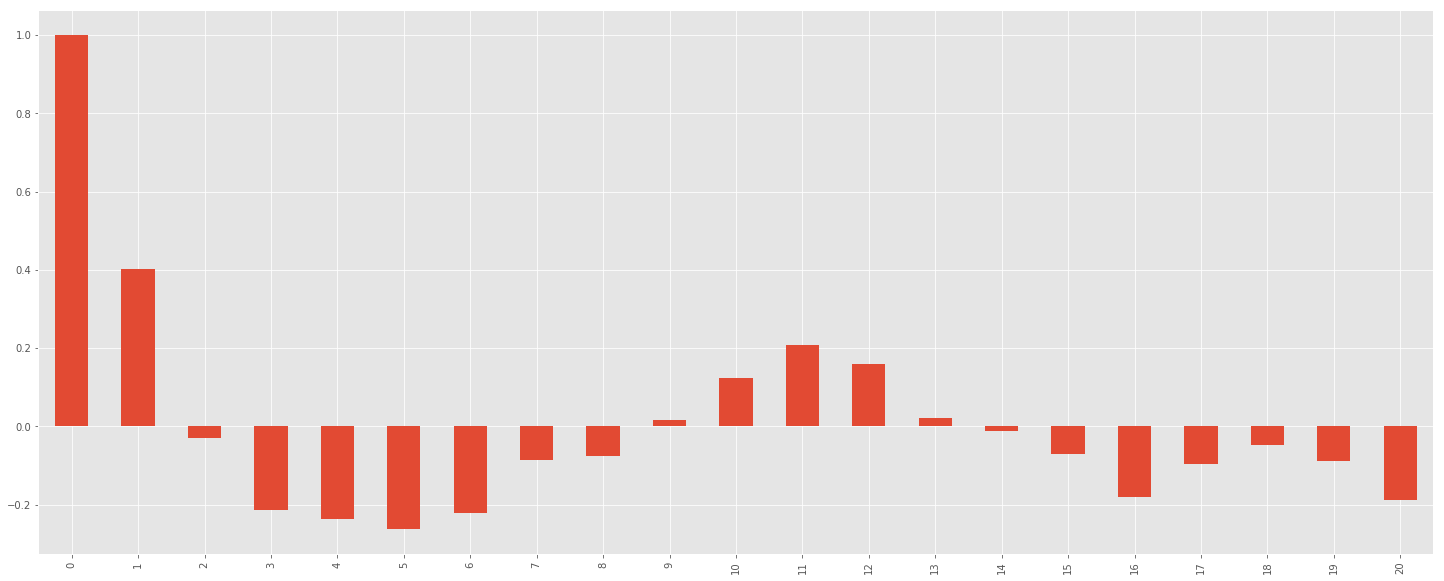

In [350]:
# Get ACF
pd.Series(acf(ts_stat, nlags=20)).plot(kind='bar')

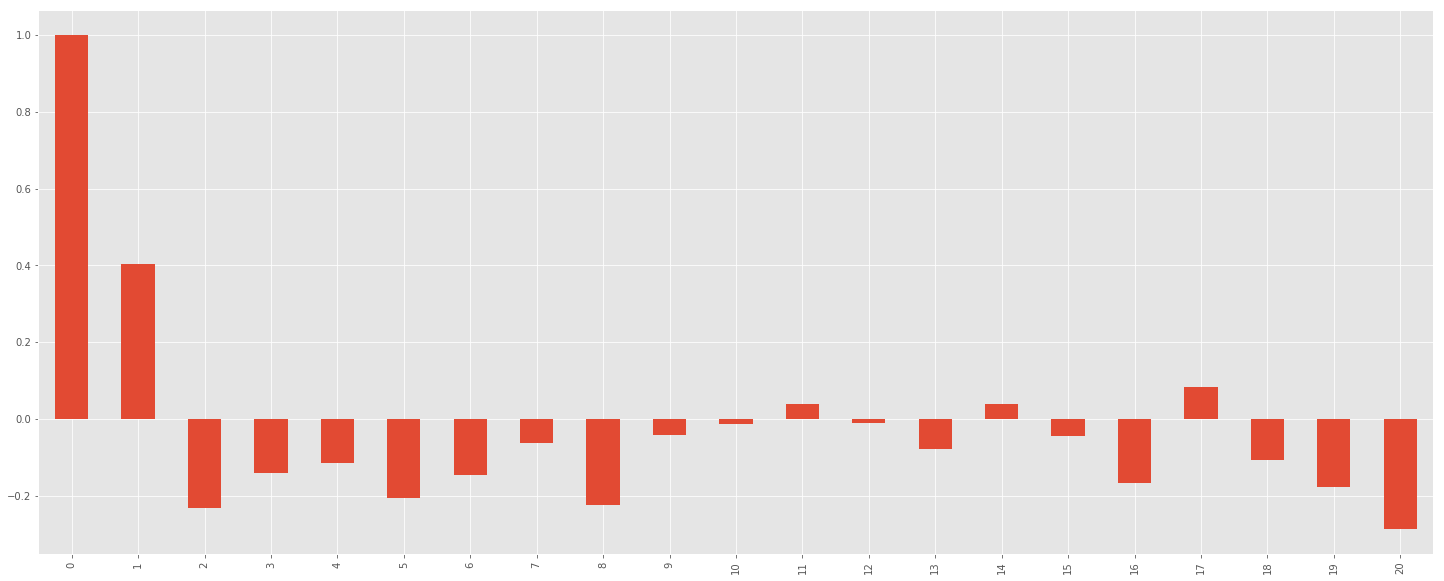

In [351]:
# Get PACF
pd.Series(pacf(ts_stat, nlags=20)).plot(kind='bar')

#### Run ARIMA model

In [352]:
from statsmodels.tsa.arima_model import ARIMA

# Fit (p=1, d=0, q=1 based on above ACF, PACF)
model = ARIMA(ts_stat, order=(1,0,1))
model_fit = model.fit(disp=-1) ; # dont display messages

# Predict
ylogdiff_pred = pd.Series(model_fit.fittedvalues, copy = True)

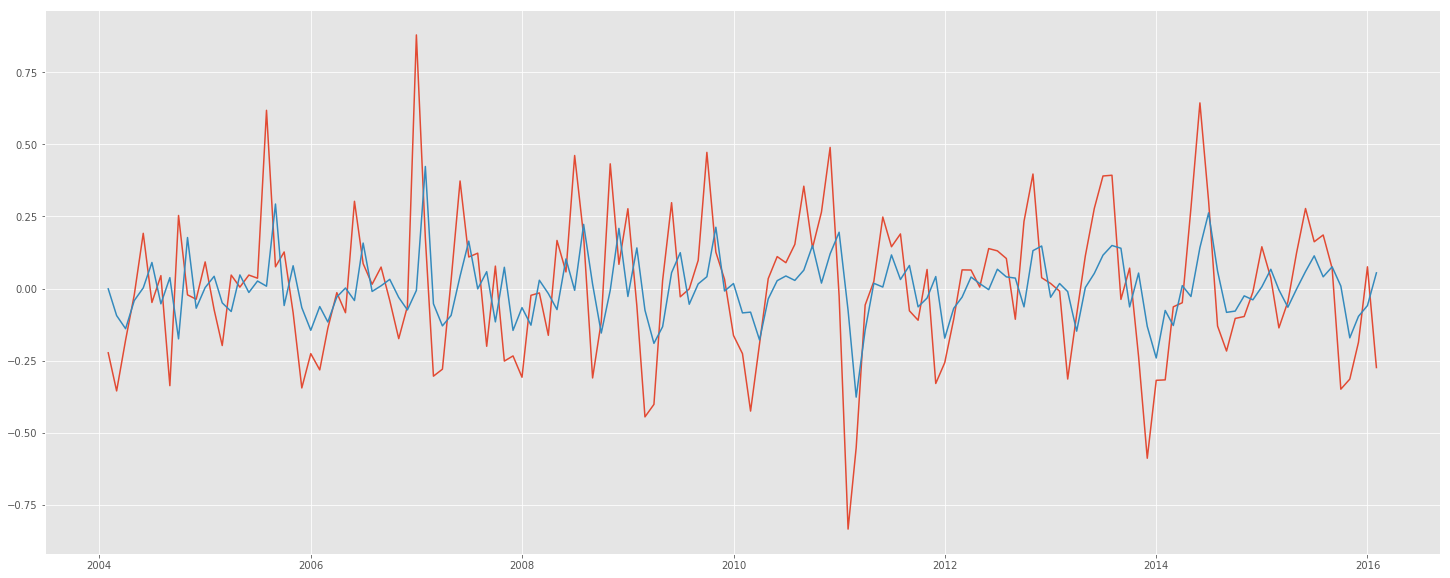

In [353]:
# Plot log arima vs orig log price
plt.plot(ts_stat)
plt.plot(ylogdiff_pred)

In [354]:
# Convert to original scale by adding back diffs
ylogdiff_pred_cumsum = ylogdiff_pred.cumsum()
ylog_pred = pd.Series(dfb.log_priceMod.iloc[0], index=dfb.log_priceMod.index)
ylog_pred = ylog_pred.add(ylogdiff_pred_cumsum, fill_value=0.0) ; # fill for t=0 where there is no ylogdiff

In [355]:
# Arima predictions
dfb['arima_mod'] = np.exp(ylog_pred)

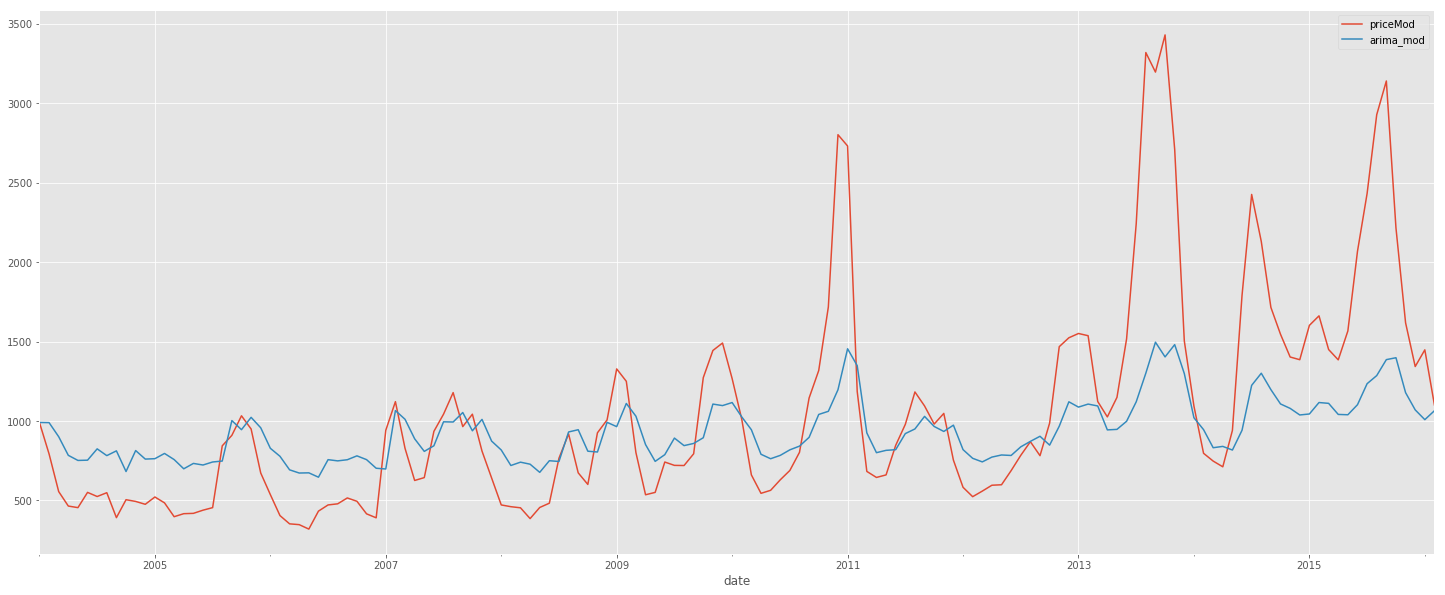

In [356]:
# Plot
model = 'arima_mod'
models = ['priceMod', model]
dfb.plot(kind = 'line', x = 'date', y= models)

In [357]:
# Error:
err = rmse(dfb[model], dfb['priceMod'])
print(err)

517.543914118


### Summary

model:priceMod	err:0.00
model:mean_mod	err:683.95
model:lin_mod_1	err:518.52
model:lin_mod_2	err:591.81
model:lin_mod_3	err:581.34
model:lin_mod_4	err:496.81
model:ewmavg_mod_12	err:547.16
model:ewmavg_mod_6	err:486.90
model:arima_mod	err:517.54


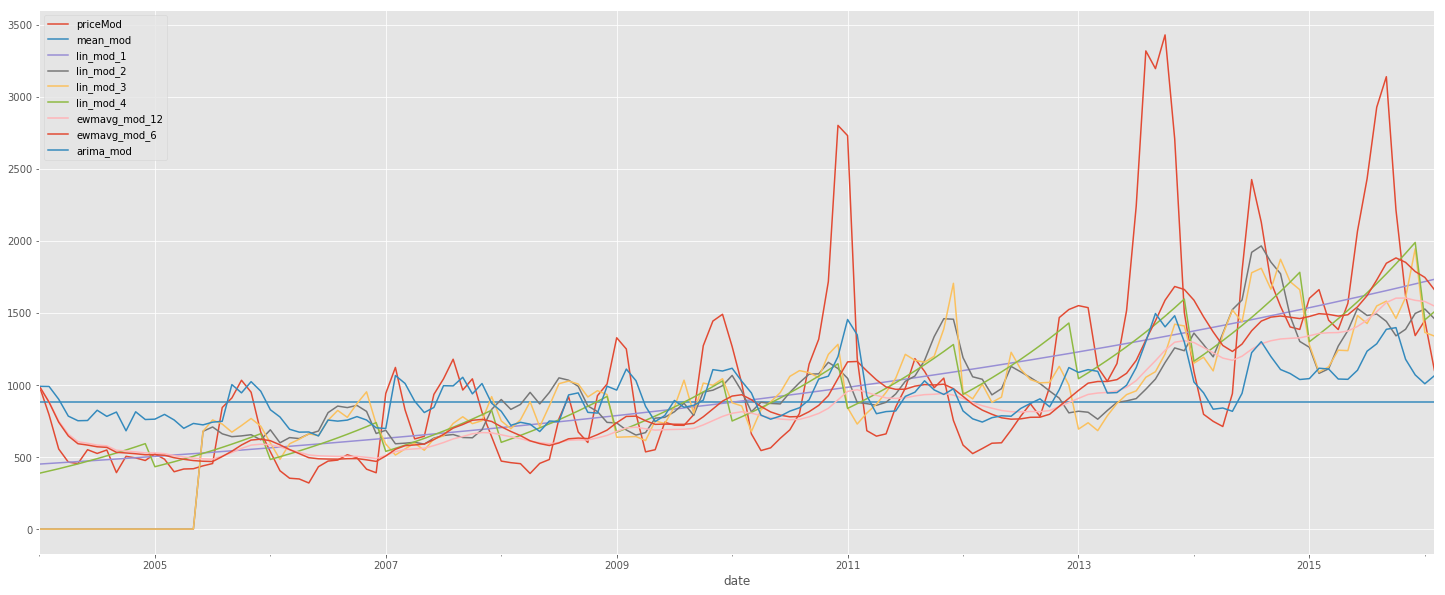

In [373]:
"""models = ['priceMod', 'mean_mod', 
       'lin_mod_1', 'lin_mod_2', 'lin_mod_3', 'lin_mod_4',
       'randwalk_mod', 'smavg_mod', 'ewmavg_mod_12', 'ewmavg_mod_6',
       'arima_mod']
"""
models = ['priceMod', 'mean_mod', 
       'lin_mod_1', 'lin_mod_2', 'lin_mod_3', 'lin_mod_4',
       'ewmavg_mod_12', 'ewmavg_mod_6',
       'arima_mod']
dfb.plot(kind = 'line', x = 'date', y= models)
for model in models:
    err = rmse(dfb[model], dfb['priceMod'])
    print("model:{}\terr:{:.2f}".format(model,err))